# Part b and c
This notebook contains a step-by-step walkthrough of task b) and c) using both code and text.
## Part b

In [1]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../..')
sys.path.append('../../src/')

### Loading the data and constructing the input matrix
The same data as from previous exercises is reused. However, as a neural network will be fitted in this case, the design matrix is not created in the same manner.

When a neural network trains on terrain data, it takes in the x and y coordinates and tries to predict the output z. As such, the design matrix should be of shape (n_samples,2). In other words, extract the data without creating a design matrix, or simply use the two columns from the original design matrix X[:,1:3].

Note that both the target data and design matrix is scaled follow the same arguments as in part a. Scaling the target data might be more beneficial with neural networks as it can help avoid exploding gradients.

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Test data'}, xlabel='X', ylabel='Y'>

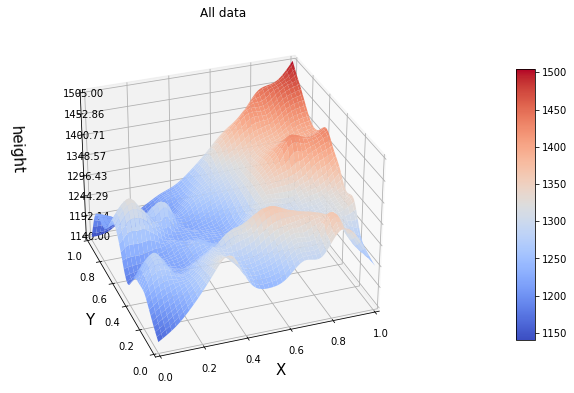

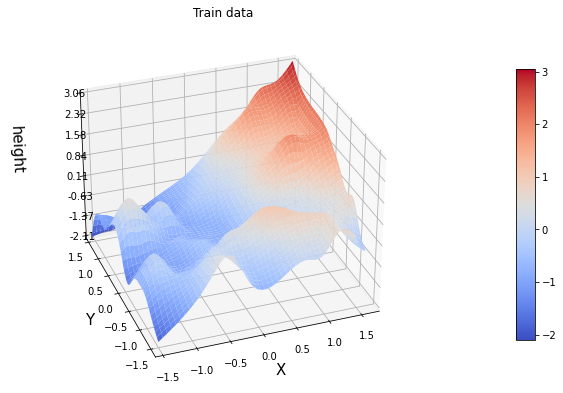

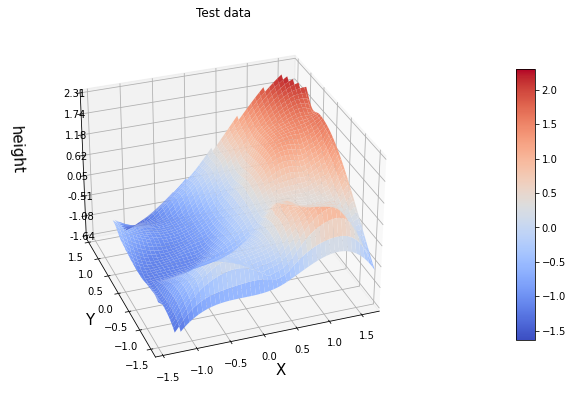

In [2]:
from src.data.create_dataset import create_dataset, create_poly_design_matrix
from sklearn.model_selection import  train_test_split
from src.visualization.visualize import plot_surf_from_X
from sklearn.preprocessing import StandardScaler

X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',downsampling = 8)


X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

#Design matrix for OLS for comparison
X_train_ols = create_poly_design_matrix(X_train,degree=5)
X_test_ols = create_poly_design_matrix(X_test,degree=5)

X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)

#Scale OLS matrix
X_scl_ols = StandardScaler().fit(X_train_ols)
X_train_ols = X_scl_ols.transform(X_train_ols)
X_test_ols = X_scl_ols.transform(X_test_ols)


plot_surf_from_X(X,z,'All data')
plot_surf_from_X(X_train,z_train,'Train data')
plot_surf_from_X(X_test,z_test,'Test data')

## Regression using Neural Network
In this part a neural network is fitted to the terrain data. In other words, it is used as regression as opposed to classification which is perhaps the more familiar.

#### Neural network in short
 A neural network consists of layers of nodes fully connected to all nodes in the layers at either side. These weighted connections goes through an activation function causing the non-linearities in the model. A node's state is the weighted sum av all activations coming in to it. Additionally there is an extra bias added to each node as a sort of "intercept".

 These weights and biases is fitted to a data set, meaning they are tuned so that when predicting output, a cost function is minimized. SGD is used very similarly as with the linear regression case, where each parameter is subtracted the gradient. In the case of neural network the gradient needs to be calculated for every connection, meaning a lot more gradients than with linear regression.

 Prediction is perform using the algorithm feedforward, which feeds the input value forward through the connections and activation functions. The update of the parameters is then done using the backpropagation algorithm, which starts by calculating the error and gradient of the last layer, and uses that result to calculate the gradient and error in the previous layer, and so forth.

 As with linear regression, momentum, regularization and different learning rate schemes may be employed.

NN train[MSE,R2]: (0.12911743805394327, 0.8708825619460567) 
NN test[MSE,R2]: (0.1820790018062524, 0.8010692338554352)
OLS train[MSE,R2]: (0.09990252233243115, 0.9000974776675689) 
OLS test[MSE,R2]: (0.13640298103639853, 0.8509726588305498)


../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Neural Network'}, xlabel='X', ylabel='Y'>

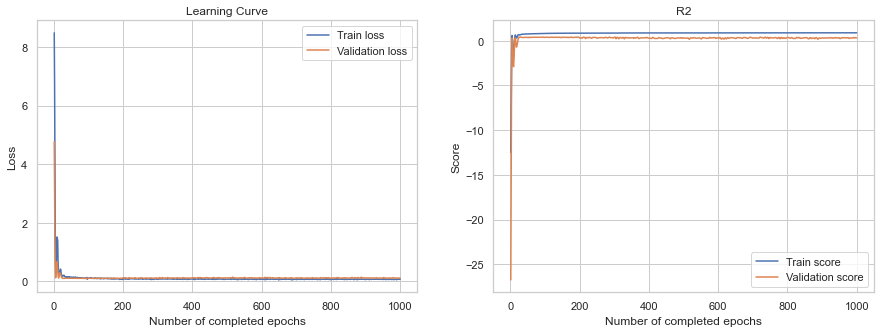

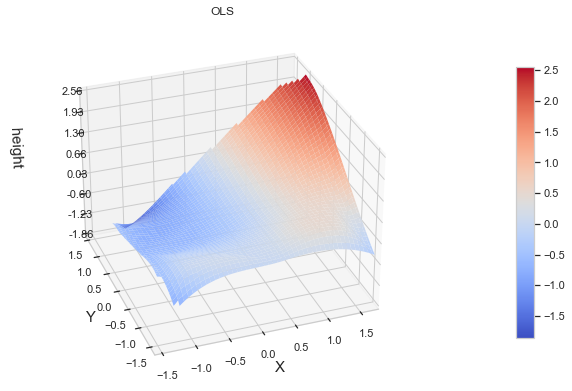

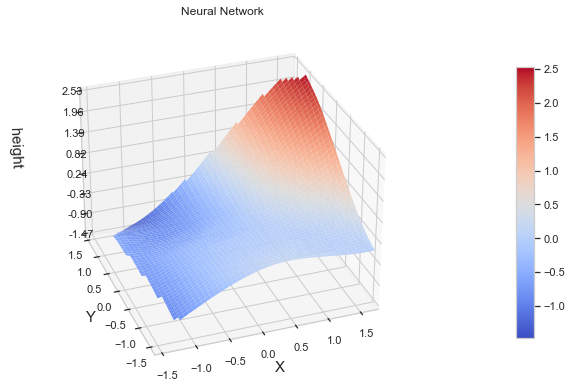

In [48]:
from src.modelling.nn import NeuralNetwork
from src.modelling.linreg import LinReg
from src.model_evaluation.metrics import MSE_R2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

#Model parameters
batch_size = 64
n_epochs = 1000
hidden_layers = (50,)
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01
lr0 = 0.01
w_init = 'normal'

#Setting loss function
loss_function = 'squared_loss'

#Fitting neural network
nn = NeuralNetwork(batch_size = batch_size,
                   n_epochs = n_epochs,
                   hidden_layer_sizes = hidden_layers, 
                   w_init = w_init,
                   momentum = momentum,
                   loss_func = loss_function,
                   val_fraction=0.1,
                   hidden_activation=hidden_activation,
                   output_activation=output_activation,
                   lmb = lmb,
                   lr0= lr0)

nn.fit(X_train,z_train)
tilde_nn = nn.predict(X_train)
pred_nn = nn.predict(X_test)

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
nn.plot_loss('Learning Curve',ax1)
nn.plot_score('R2',ax2)

#Fitting ols for comparison
ols =LinReg(regularization = None).fit(X_train_ols,z_train)
tilde_ols = ols.predict(X_train_ols)
pred_ols = ols.predict(X_test_ols)

train_mse_nn, train_r2_nn = MSE_R2(z_train,tilde_nn)
test_mse_nn, test_r2_nn = MSE_R2(z_test ,pred_nn)
train_mse_ols, train_r2_ols = MSE_R2(z_train,tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,pred_ols)

#Printing the scores
print('NN train[MSE,R2]:',(train_mse_nn, train_r2_nn), '\nNN test[MSE,R2]:',(test_mse_nn, test_r2_nn))
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))


#Plotting the test data
plot_surf_from_X(X_test,pred_ols,'OLS')
plot_surf_from_X(X_test,pred_nn,'Neural Network')

The neural network is able to achieve a relatively high R2 score and low MSE, though still somewhat worse than OLS. This is also clear from the plot, OLS seems more convincing if compared to real terrain data. However, for using only one layer and sigmoid as activation function, the results are good.

When creating a neural network, it's weights and biases needs to be initialized. In the case above, the weights were initialized with a normal distribution with mean 0 and var 1. The biases were simply initialized to 0.001 as to not be 0. Another common and relatively new way of initializing the weights is according to Glorot et al. Here the weights are initated with a uniform(normal may be used too) distribution with upper and lower limits according to sqrt(6/(n_features+n_neurons)). As such the initialization is dependent on the specific layer settings. The 'glorot' initialization helps ensure a similar variance of the output values as the input values, which in turn help avoid exploding/vanishing gradients.

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


NN train[MSE,R2]: (0.32273800610062164, 0.6772619938993782) 
NN test[MSE,R2]: (0.27302071179414833, 0.7017106924370269)
NN SK train[MSE,R2]: (0.3682661630172308, 0.6317338369827692) 
NN SK test[MSE,R2]: (0.32243156089984926, 0.6477267735285201)
OLS train[MSE,R2]: (0.09990252233243115, 0.9000974776675689) 
OLS test[MSE,R2]: (0.13640298103639853, 0.8509726588305498)


<Axes3DSubplot:title={'center':'Sklearn MLPRegressor'}, xlabel='X', ylabel='Y'>

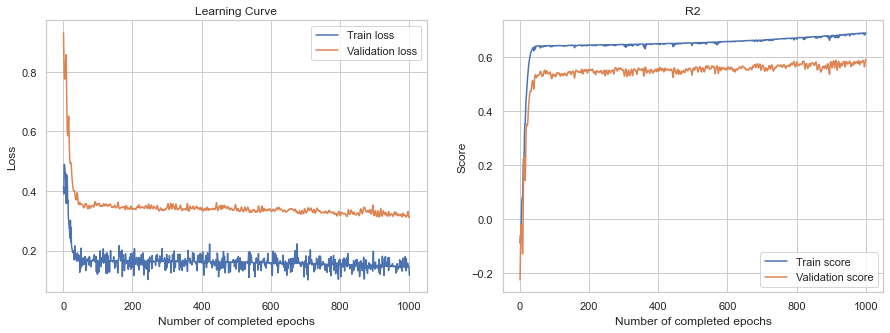

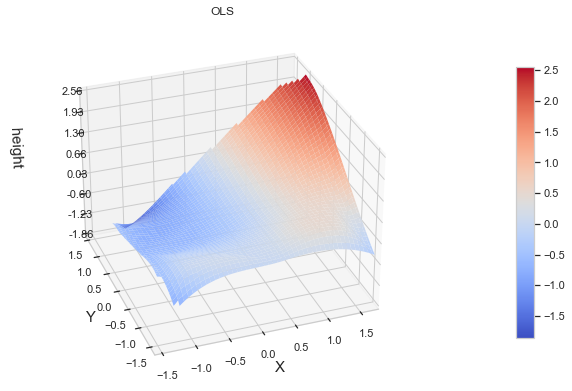

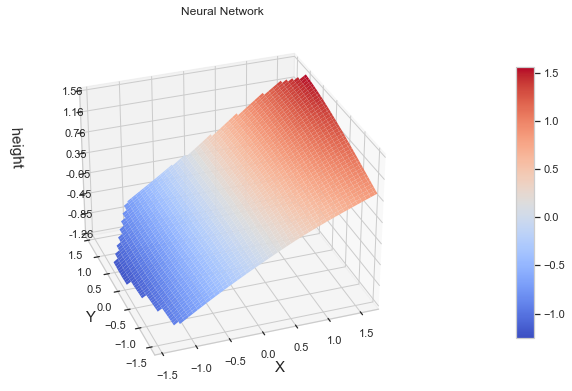

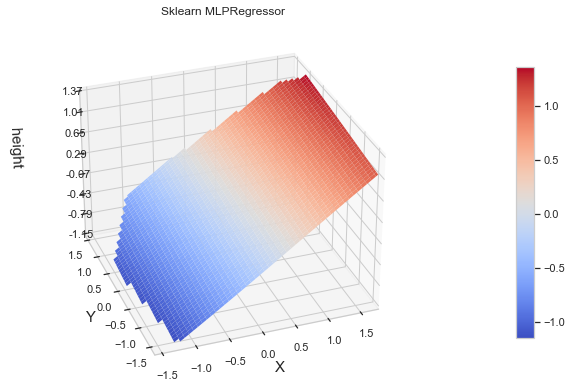

In [50]:
from sklearn.neural_network import MLPRegressor

#Model parameters
batch_size = 64
n_epochs = 1000
hidden_layers = (50,)
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01
lr0 = 0.01
w_init = 'glorot' #Changed initialization scheme

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)
#Fitting network
nn.fit(X_train,z_train)

nn_sk = MLPRegressor(batch_size = batch_size,
                     max_iter = n_epochs,
                     alpha=lmb,
                     hidden_layer_sizes = hidden_layers, 
                     activation='logistic',
                     solver = 'sgd',
                     learning_rate_init=lr0,
                     tol = 0,
                     momentum = 0.5,
                     validation_fraction = 0)
nn_sk.fit(X_train,z_train)

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
nn.plot_loss('Learning Curve',ax1)
nn.plot_score('R2',ax2)
#Own preds
tilde_nn = nn.predict(X_train)
pred_nn = nn.predict(X_test)
#SK preds
tilde_sk = nn_sk.predict(X_train).reshape(-1,1)
pred_sk = nn_sk.predict(X_test).reshape(-1,1)

#Calcluating MSE and R2
train_mse_nn, train_r2_nn = MSE_R2(z_train,tilde_nn)
test_mse_nn, test_r2_nn = MSE_R2(z_test ,pred_nn)
train_mse_sk, train_r2_sk = MSE_R2(z_train,tilde_sk)
test_mse_sk, test_r2_sk = MSE_R2(z_test ,pred_sk)

#Printing the scores
print('NN train[MSE,R2]:',(train_mse_nn, train_r2_nn), '\nNN test[MSE,R2]:',(test_mse_nn, test_r2_nn))
print('NN SK train[MSE,R2]:',(train_mse_sk, train_r2_sk), '\nNN SK test[MSE,R2]:',(test_mse_sk, test_r2_sk))
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))

#Plotting the test data
plot_surf_from_X(X_test,pred_ols,'OLS')
plot_surf_from_X(X_test,pred_nn,'Neural Network')
plot_surf_from_X(X_test,pred_sk,'Sklearn MLPRegressor')

In this case a normal distribution did in fact provide a better fit than glorot. It may be due to the combination of initialization and activation function, which will be explored later. The surface does at least increase its height along the right xy direction. The manually written neural network performed slightly better than the sklearn's neural network. It may well be due to the stochasticity of weight initialization and in sgd in general. For proper benchmark, cross validation should be employed. However, before that, further parameter analysis is conducted.

In [8]:
for layer in nn.layers:
    print(layer.weights)

[[ 0.127286   -0.35750766 -0.19645299  0.04195068  0.16553948  0.48400527
   0.16117598 -0.68907863  0.27160686 -0.24824506  0.20078203 -0.26882483
   0.29271554  0.08782058 -0.08350478 -0.42606025 -0.1867301   0.07821908
   0.54681717 -0.03632558 -0.20704106  0.08131325  0.33608848 -0.38018173
  -0.08898265 -0.43467525 -0.16779938 -0.30152397  0.02082864 -0.09419563
   0.51318714  0.49150274 -0.06868868 -0.31258523  0.41173279 -0.20362803
  -0.12626779  0.20476717  0.02761598 -0.30527419 -0.22311611  0.30310257
   0.17234127 -0.22591492  0.06072878  0.09041834 -0.11714827  0.03517318
   0.32041148  0.01638886]
 [ 0.06276038 -0.2366195  -0.16064166  0.01312578 -0.04859331  0.01181235
   0.01402309  0.23308179  0.06824434 -0.23612479 -0.26444949  0.16082627
   0.19809615  0.30348419 -0.25593386 -0.2295917   0.11706833  0.00891057
  -0.23509401 -0.11848255 -0.15289988 -0.27492858 -0.3082138  -0.11417071
   0.36998331  0.11238957 -0.31412756  0.17077939  0.28267847 -0.00409686
   0.095187

Inspecting the weights, it does not seem like the network suffers from vanishing gradients. The weights will be initialized with normal distribution going forward.

### Tuning parameters
#### Gridsearching learning rate and lambda
Similarily as with SGD regression performing a grid search on the lr and lmb is a common first step.

../..\src\model_evaluation\metrics.py:8: RuntimeWarning: overflow encountered in square
  return 1 - sum((target - prediction) ** 2) / sum((target - mean(target)) ** 2)
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:458: Runtim

../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\model_evaluation\metrics.py:8: RuntimeWarning: overflow encountered in square
  return 1 - sum((target - prediction) ** 2) / sum((target - mean(target)) ** 2)
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\model_evaluation\metrics.py:8: RuntimeWarning: overflow encountered in square
  return 1 - sum((target - prediction) ** 2) / sum((target - mean(target)) ** 2)
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul

../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWar

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60316039 0.71450413 0.76024995 0.80918918 0.8285897  0.85335561
 0.83667988        nan 0.57827549 0.69860888 0.75263928 0.82584057
 0.83495797 0.83142416 0.84387059        nan 0.5046234  0.76688828
 0.75911603 0.81117137 0.82921742 0.85600519 0.81601297        nan
 0.665419   0.68970807 0.76167178 0.82744468 0.8218683  0.83929667
 0.83779009        nan 0.57195993 0.71785895 0.77556104 0.833125
 0.82432313 0.86080006 0.8580915         nan 0.60264298 0.69093949
 0.76349602 0.82758592 0.82056724 0.81644745 0.81680143        nan
 0.62058546 0.69040997 0.7667404  0.82346561 0.82541987 0.79398834
 0.81302628        nan 0.64173038 0.66479639 0.68034577 0.60172256
 0.60181956 0.59726159 0.57488526        nan]
  warnings.warn(


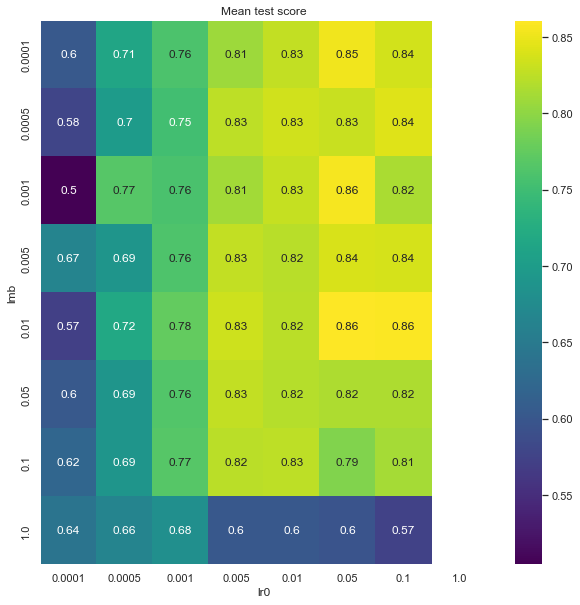

lmb                0.0100
lr0                0.0500
mean_test_score    0.8608
rank_test_score         1
Name: 37, dtype: object


In [51]:
from src.model_evaluation.param_analysis import grid_search_df
from src.visualization.visualize import plot_grid_search

#Model parameters
batch_size = 64
n_epochs = 1000
hidden_layers = (50,)
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01
lr0 = 0.01
w_init = 'normal' #Changed initialization scheme

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)

lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]
lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]
best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))
print(scores.loc[scores['rank_test_score'].idxmin()])

The grid search results shows that a relatively high learning rate is preferred, however increasing it any more leads to exploding gradients and thereby invalid values in the results(no value). Decreasing it below 0.005 leads to a substantially lower score. In other words, there seems to be a small interval where the learning rate does not cause vanishing/exploding gradients. This may be because of the activation function currently used. 

Anyhow, lr0 = 0.05 and lmb = 0.01 gives the best score and will be used further.

NN train[MSE,R2]: (0.11942081289853998, 0.88057918710146) 
NN test[MSE,R2]: (0.14385265065524758, 0.8428335078570703)
OLS train[MSE,R2]: (0.09990252233243115, 0.9000974776675689) 
OLS test[MSE,R2]: (0.13640298103639853, 0.8509726588305498)


../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Neural Network'}, xlabel='X', ylabel='Y'>

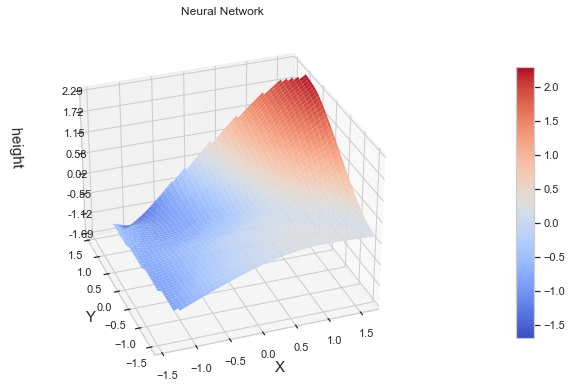

In [52]:
#Model parameters
batch_size = 64
n_epochs = 1000
hidden_layers = (50,)
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  #Changed lmb to semi-optimal from gridsearch
lr0 = 0.05   #Changed lr0 to semi-optimal from gridsearch
w_init = 'normal' 

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)
#Fitting
nn.fit(X_train,z_train)

#Predicting
tilde_nn = nn.predict(X_train)
pred_nn = nn.predict(X_test)
train_mse_nn, train_r2_nn = MSE_R2(z_train,tilde_nn)
test_mse_nn, test_r2_nn = MSE_R2(z_test ,pred_nn)

print('NN train[MSE,R2]:',(train_mse_nn, train_r2_nn), '\nNN test[MSE,R2]:',(test_mse_nn, test_r2_nn))
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
plot_surf_from_X(X_test,pred_nn,'Neural Network')

The surface plot is somewhat more convincing than initially obtained from neural network. Both train and test score are slightly higher than that of the linear regression. However, again a proper cross validation should be done for benchmarking.

By further employing the achieved parameters, a new gridsearch can be conducted on other parameters.
#### Grid searching hidden layer sizes and batch size
Several network architectures are tested together with several batch sizes to further optimize the model.

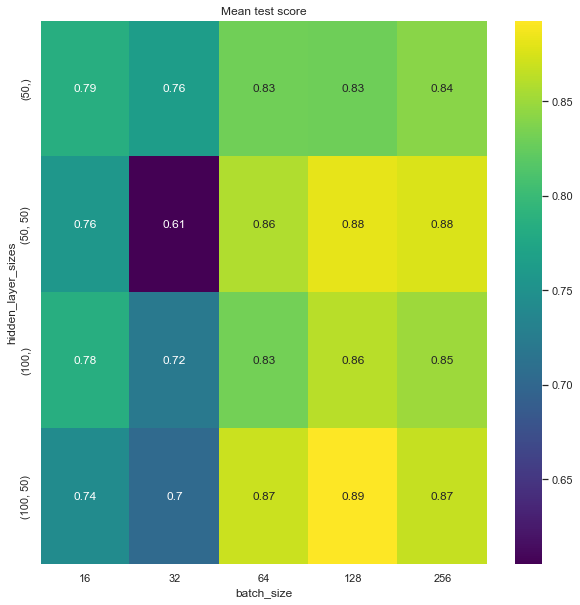

hidden_layer_sizes    (100, 50)
batch_size                  128
mean_test_score        0.892495
rank_test_score               1
Name: 15, dtype: object


In [53]:
hidden_layers_list = [(50,),(100,),(50,50),(100,50)]
batch_sizes = [16, 32, 64, 128, 256]

#Model parameters
batch_size = 64
n_epochs = 1000
hidden_layers = (50,)
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  #Changed lmb to semi-optimal from gridsearch
lr0 = 0.05   #Changed lr0 to semi-optimal from gridsearch
w_init = 'normal' 

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(hidden_layer_sizes=hidden_layers_list,
                                                                        batch_size=batch_sizes))
plot_grid_search(scores,('hidden_layer_sizes','batch_size'))
print(scores.loc[scores['rank_test_score'].idxmin()])

The network seems to be able to score well with all tested architectures. However it is preferrable to keep it as simple as possible. As such, (50,50) and batch_size 128 is chosen going forward.

NN train[MSE,R2]: (0.09032340000327554, 0.9096765999967245) 
NN test[MSE,R2]: (0.10589366641391537, 0.8843056696236029)
OLS train[MSE,R2]: (0.09990252233243115, 0.9000974776675689) 
OLS test[MSE,R2]: (0.13640298103639853, 0.8509726588305498)


../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Neural Network'}, xlabel='X', ylabel='Y'>

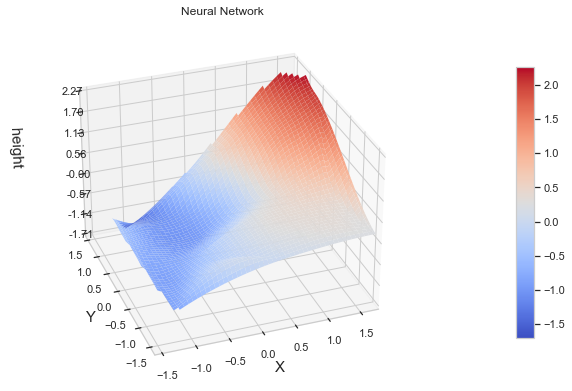

In [54]:
#Model parameters
batch_size = 128 #Changed lmb to semi-optimal from gridsearch
n_epochs = 1000
hidden_layers = (50,50)  #Changed lr0 to semi-optimal from gridsearch
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  
lr0 = 0.05   
w_init = 'normal' 

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)
#Fitting
nn.fit(X_train,z_train)

tilde_nn = nn.predict(X_train)
pred_nn = nn.predict(X_test)
train_mse_nn, train_r2_nn = MSE_R2(z_train,tilde_nn)
test_mse_nn, test_r2_nn = MSE_R2(z_test ,pred_nn)

print('NN train[MSE,R2]:',(train_mse_nn, train_r2_nn), '\nNN test[MSE,R2]:',(test_mse_nn, test_r2_nn))
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
plot_surf_from_X(X_test,pred_nn,'Neural Network')

The neural network has become quite capable of reproducing the terrain data.
#### Benmarking NerualNetwork vs OLS
With the currently found parameters, crossvaldiation is conducted to benchmark the NeuralNetwork's performance compared to OLS. Note that different activation functions will be studied in the next part.

In [55]:
from src.model_evaluation.resampling import cross_val_score

#Model parameters
batch_size = 128  #Changed batch_size to semi-optimal from gridsearch
n_epochs = 1000
hidden_layers = (50,50)  #Changed layers to semi-optimal from gridsearch
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  
lr0 = 0.05   
w_init = 'normal' 

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)

nn_scores =  cross_val_score(nn,X,z,5,X_scl,z_scl,['MSE','R2'])
X_ols = create_poly_design_matrix(X,degree=5)
ols_scores =  cross_val_score(ols,X_ols,z,5,X_scl,z_scl,['MSE','R2'])

print('CV results:\n')
print('NN train[MSE,R2]:',(nn_scores['train']['MSE'], nn_scores['train']['R2']), '\nNN test[MSE,R2]:',(nn_scores['test']['MSE'], nn_scores['test']['R2']))
print('OLS train[MSE,R2]:',(ols_scores['train']['MSE'], ols_scores['train']['R2']), '\nOLS test[MSE,R2]:',(ols_scores['test']['MSE'], ols_scores['test']['R2']))

CV results:

NN train[MSE,R2]: (0.07607564654767418, 0.9239243534523258) 
NN test[MSE,R2]: (0.10684046082190704, 0.8886628587077728)
OLS train[MSE,R2]: (0.09594323734807618, 0.9040567626519238) 
OLS test[MSE,R2]: (0.14771293894115495, 0.8518278575248545)


The neural network does achieve good results. OLS still achieves better train results, however nn scores slightly better on the test set than OLS, indicating that it's better at generalizing.

## Part c
Sigmoid, ReLU and LeakyReLU will be tested and compared as hidden activation functions. Additionally, several weight initalization methods will be tested with the different activation functions. The parameters found using grid search:

n_epochs = 1000

batch_size = 64

lr = 0.05

lmb = 0.01, will be further employed. 

../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:448: RuntimeWarning: overflow encountered in matmul
  error = (error @ weights.T)*self.layers[i].derivative(self.layers[i].z_h,error)
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src

../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:396: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
../..\src\modelling\nn.py:379: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
../..\src\m

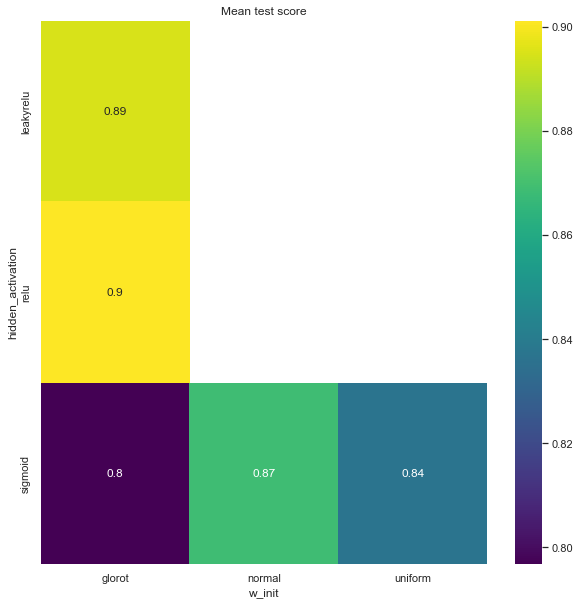

hidden_activation        relu
w_init                 glorot
mean_test_score      0.901133
rank_test_score             1
Name: 0, dtype: object


In [56]:
activation_funcs = ['relu','leakyrelu','sigmoid']
w_inits = ['glorot','uniform','normal']

#Model parameters
batch_size = 128  #Changed batch_size to semi-optimal from gridsearch
n_epochs = 1000
hidden_layers = (50,50)  #Changed layers to semi-optimal from gridsearch
hidden_activation = 'sigmoid'
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  
lr0 = 0.05   
w_init = 'normal' 

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(hidden_activation=activation_funcs,w_init=w_inits))
plot_grid_search(scores,('hidden_activation','w_init'))
print(scores.loc[scores['rank_test_score'].idxmin()])

From the gridsearch it seems that the relu together with uniform initialization achieves best results. It can be noted that sigmoid in general seems to perform poorly. Additionally, using normal and relu seems to cause divergence.

In [57]:
#Model parameters
batch_size = 128 
n_epochs = 1000
hidden_layers = (50,50)  
hidden_activation = 'relu' #activation to optimal from gridsearch
output_activation = 'identity'
momentum = 0.9
lmb = 0.01  
lr0 = 0.05   
w_init = 'glorot'  #Changed w_init optimal from gridsearch

nn_scores =  cross_val_score(nn,X,z,5,X_scl,z_scl,['MSE','R2'])
ols_scores =  cross_val_score(ols,X_ols,z,5,X_scl,z_scl,['MSE','R2'])

print('CV results:\n')
print('NN train[MSE,R2]:',(nn_scores['train']['MSE'], nn_scores['train']['R2']), '\nNN test[MSE,R2]:',(nn_scores['test']['MSE'], nn_scores['test']['R2']))
print('OLS train[MSE,R2]:',(ols_scores['train']['MSE'], ols_scores['train']['R2']), '\nOLS test[MSE,R2]:',(ols_scores['test']['MSE'], ols_scores['test']['R2']))


CV results:

NN train[MSE,R2]: (0.07097074356633153, 0.9290292564336685) 
NN test[MSE,R2]: (0.1102083909353738, 0.8880161140402351)
OLS train[MSE,R2]: (0.09778083675771598, 0.9022191632422839) 
OLS test[MSE,R2]: (0.12628401018373198, 0.8531670260724635)


The cv results shows that the Neural Network is able to achieve good results after having tuned it. Note that choosing for instance relu and glorot from the beginning, and tuning parameters thereafter, could result in different performance. However, one has to start somewhere. For a more thourough analysis, one could do the same analysis with several activation functions and initialization methods.

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Neural Network'}, xlabel='X', ylabel='Y'>

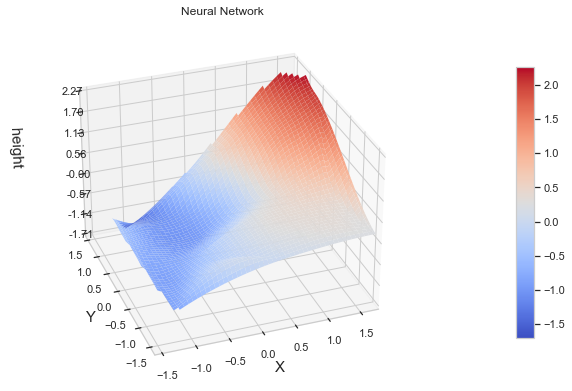

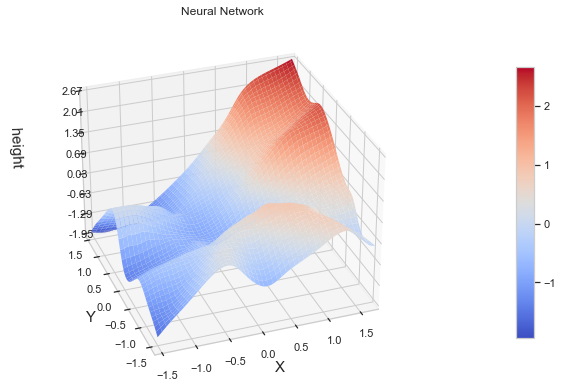

In [58]:
X_ = np.concatenate((X_train,X_test))

#Setting new parameters
nn.set_params(batch_size = batch_size,
              n_epochs = n_epochs,
              hidden_layer_sizes = hidden_layers, 
              w_init = w_init,
              momentum = momentum,
              hidden_activation=hidden_activation,
              output_activation=output_activation,
              lmb = lmb,
              lr0= lr0)

nn.fit(X_train,z_train)

nn_tilde = nn.predict(X_train)
nn_pred = nn.predict(X_test)

plot_surf_from_X(X_test,pred_nn,'Neural Network')
plot_surf_from_X(X_,np.concatenate((nn_tilde,nn_pred)),'Neural Network')

The final surfaces are quite convincing.